# Notebook to get qhat in David's approach

### Simulation parameters

In [2]:
import numpy as np

# hbar * c [GeV * fm]
hbarc = 0.197326 

# Simulation box 
L = 1         
N = 128 
tau_sim = 0.25    
DTS = 8

# Derived parameters
a = L/N
E0 = N / L * hbarc
DT = 1.0 / DTS
maxt = int(tau_sim / a * DTS)
nplus = maxt//DTS

# Glasma fields
su_group = 'su3'
uv = 10.0
ir = 0.2
g2mu = 1.5


g = 2         		
mu = g2mu / g**2

ns = 50      


nevents = 10

### Enviroment variables

In [3]:
import os

# Comment this, I need it for JYU GPUs to choose a specific GPU to run on
# os.environ["CUDA_VISIBLE_DEVICES"]="2,4,7"

# os.environ["MY_NUMBA_TARGET"] = "numba"
os.environ["MY_NUMBA_TARGET"] = "cuda"
os.environ["PRECISION"] = "double"
os.environ["GAUGE_GROUP"] = su_group

# Import relevant modules
import sys
sys.path.append('..')

# Glasma modules
import curraun.core as core
import curraun.mv as mv
import curraun.initial as initial
initial.DEBUG = False

import curraun.su as su
from curraun.numba_target import use_cuda
if use_cuda:
    from numba import cuda

# Qhat module
import curraun.qhat as qhat
import curraun.qhat_qeik as qhat_qeik

import pickle
from tqdm import tqdm

/home2/carlos.lamas/condacurraun/lib/python3.10/site-packages/scipy/__init__.py:132: UserWarning: A NumPy version >=1.21.6 and <1.28.0 is required for this version of SciPy (detected version 1.21.5)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Using CUDA
Using SU(3)
Using double precision


### We simulate the events

In [4]:
def simulate_qhat(ev): 
    # Derived parameters
    a = L / N
    E0 = N / L * hbarc
    DT = 1.0 / DTS
    maxt = int(tau_sim / a * DTS)

    # Initialize Glasma fields
    s = core.Simulation(N, DT, g)
    va = mv.wilson(s, mu=mu / E0, m=ir / E0, uv=uv / E0, num_sheets=ns)
    vb = mv.wilson(s, mu=mu / E0, m=ir / E0, uv=uv / E0, num_sheets=ns)
    initial.init(s, va, vb)

    # Initialize the Qhat module
    qhat_tforce = qhat.TransportedForce(s)
    qhat_qeik_tforce = qhat_qeik.TransportedForce(s)  
    # xplus = []
    mom_broad, xplus =  [], []
    mom_broad_qeik =  []

    if use_cuda:
        qhat_tforce.copy_to_device()
        qhat_qeik_tforce.copy_to_device()

    with tqdm(total=maxt) as pbar:
        for t in range(maxt):
            # Compute momentum broadening from Qhat module
            if t % DTS == 0:
                if use_cuda:
                    qhat_tforce.copy_mean_to_host()
                    qhat_qeik_tforce.copy_mean_to_host()

                # Units GeV^2
                mom_broad.append(qhat_tforce.p_perp_mean * E0 ** 2)
                mom_broad_qeik.append(qhat_qeik_tforce.p_perp_mean * E0 ** 2)
                # Units GeV^-1
                xplus.append(2*t*a/DTS/hbarc)
                
                if use_cuda:
                    qhat_tforce.copy_mean_to_device()
                    qhat_qeik_tforce.copy_mean_to_device()
            qhat_tforce.compute()
            qhat_qeik_tforce.compute()

            # Evolve Glasma fields
            core.evolve_leapfrog(s)

            pbar.set_description("Event " + str(ev+1))
            pbar.update(1)

    return mom_broad, mom_broad_qeik, xplus
    # return mom_broad_qeik, xplus

In [5]:
import warnings
warnings.filterwarnings('ignore')

mom_broads = []
mom_broads_qeik = []
for ev in range(nevents):
    mom_broad_ev, mom_broad_qeik_ev, xplus = simulate_qhat(ev)
    # mom_broad_qeik_ev, xplus = simulate_qhat(ev)
    mom_broads.append(mom_broad_ev)
    mom_broads_qeik.append(mom_broad_qeik_ev)

mom_broad = np.mean(mom_broads, axis=0)
mom_broad_qeik = np.mean(mom_broads_qeik, axis=0)

# mom_sigma = np.std(mom_broads, axis=0)/np.sqrt(N)

Event 10: 100%|██████████| 256/256 [00:02<00:00, 91.87it/s]


### We plot the momentum broadening and qhat separately for z and y

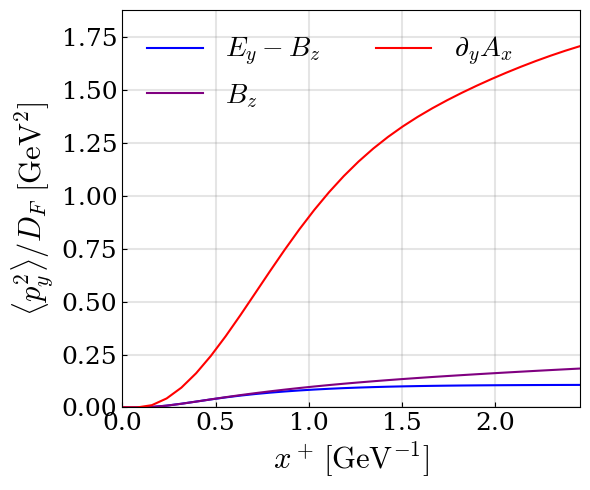

In [6]:
import matplotlib.pyplot as plt

plt.rcParams['font.family'] = 'DejaVu Serif'
plt.rcParams['font.serif'] = ['DejaVu Serif']
plt.rcParams['mathtext.fontset'] = 'cm'

plt.figure(figsize=(6, 5))

plt.tick_params(axis='both', direction='in')
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

plt.plot(xplus, mom_broad[:, 1]/3, label=r"$E_y-B_z$", linewidth=1.5, color='blue')
plt.plot(xplus, mom_broad_qeik[:, 2]/3, label=r"$B_z$", linewidth=1.5, color='purple')   
plt.plot(xplus, mom_broad_qeik[:, 0]/3, label=r"$\partial_y A_x$", linewidth=1.5, color='red')    
# # plt.plot(xplus, mom_broad_qeik[:, 1], label="DyAx-DxAy")   

plt.xlim([0, max(xplus)])
plt.ylim([0, max(mom_broad_qeik[:, 0]/3)*1.1])
plt.xlabel(r"$x^+\,\mathrm{[GeV^{-1}]}$", fontsize=22)
plt.ylabel(r"$\langle p_y^2\rangle/D_F\,\,\mathrm{[GeV^{2}]}$", fontsize=22)

plt.grid(color='gray', linestyle='-', linewidth=1.5, alpha=0.2)
plt.legend(fontsize=20, frameon=False, ncol=2, loc='upper left')

plt.tight_layout()
plt.savefig('classical_vs_quantum_mom_broad_y.png', facecolor='w', dpi=600)

plt.show()

In [7]:
# We save to file

np.savetxt('Jets in Glasma Results/QM_results/classical_py.txt', [xplus, mom_broad_qeik[:, 0]/3], fmt='%f')

### Compute canonic $\hat{q}_y$

In [8]:
qhat = np.diff(mom_broad_qeik[:, 0]/3)/np.diff(xplus)

In [9]:
np.savetxt('Jets in Glasma Results/QM_results/classical_qy.txt', [xplus[1:len(xplus)], qhat], fmt='%f')